In [10]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import sim_models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
from autocorr_time import integrated_time

In [11]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
# parameterization = 'init-f-wave'
parameterization = 'sim_bs_C'

# Use theory cov?
use_theory_cov = True

# # Information about the sampling
# n_burn = 50000
# n_steps = 200000

number = 0
titles = ['SONIK Data 0.676 MeV - 2.624 MeV\nWith theory covariance']

# Samples file
numbers = 0
file_name = './04_23_2024/run{}/samples_{}.npz'.format(numbers, numbers)

# Plot things?
plot_trace = False
plot_prob = False

# Set a specific prior? (Default set: None)
param_bounds = None
params_prior = None

# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = False
# Cross sections file (If I precompute them)
cross_section_file = None


In [12]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

In [13]:
if parameterization == 'sim_bs_C':
    labels = ['$\\bar{c}^{2}$', '$\Lambda_{B}$', '$A_{0}$', '$r_{0}$', '$(C_{1}^{+})^{2}$', '$P_{1}^{+}$', '$(C_{1}^{-})^{2}$', '$P_{1}^{-}$']
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = sim_models.Sim_BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
else:
    sys.stderr.write('Nothing else is implemented yet...')
    sys.exit(-1)

# Add normalization labels
if labels is not None:
    for i in range(0, int(np.max(norm_group) + 1)):
        labels.append('$f_{}$'.format(i))

In [14]:
# Load in the samples
all_samples = np.load(file_name)['arr_0']

samples_not_flat = all_samples[0] # Just the beta = 1 samples
# Swap axes so it is in the shape (step, walker, parameter)
samples_not_flat = np.swapaxes(samples_not_flat, 0, 1)

# # Reshape the samples
# len0, len1, len2 = samples_not_flat.shape
# samples = np.reshape(samples_not_flat, (len0 * len1, len2))

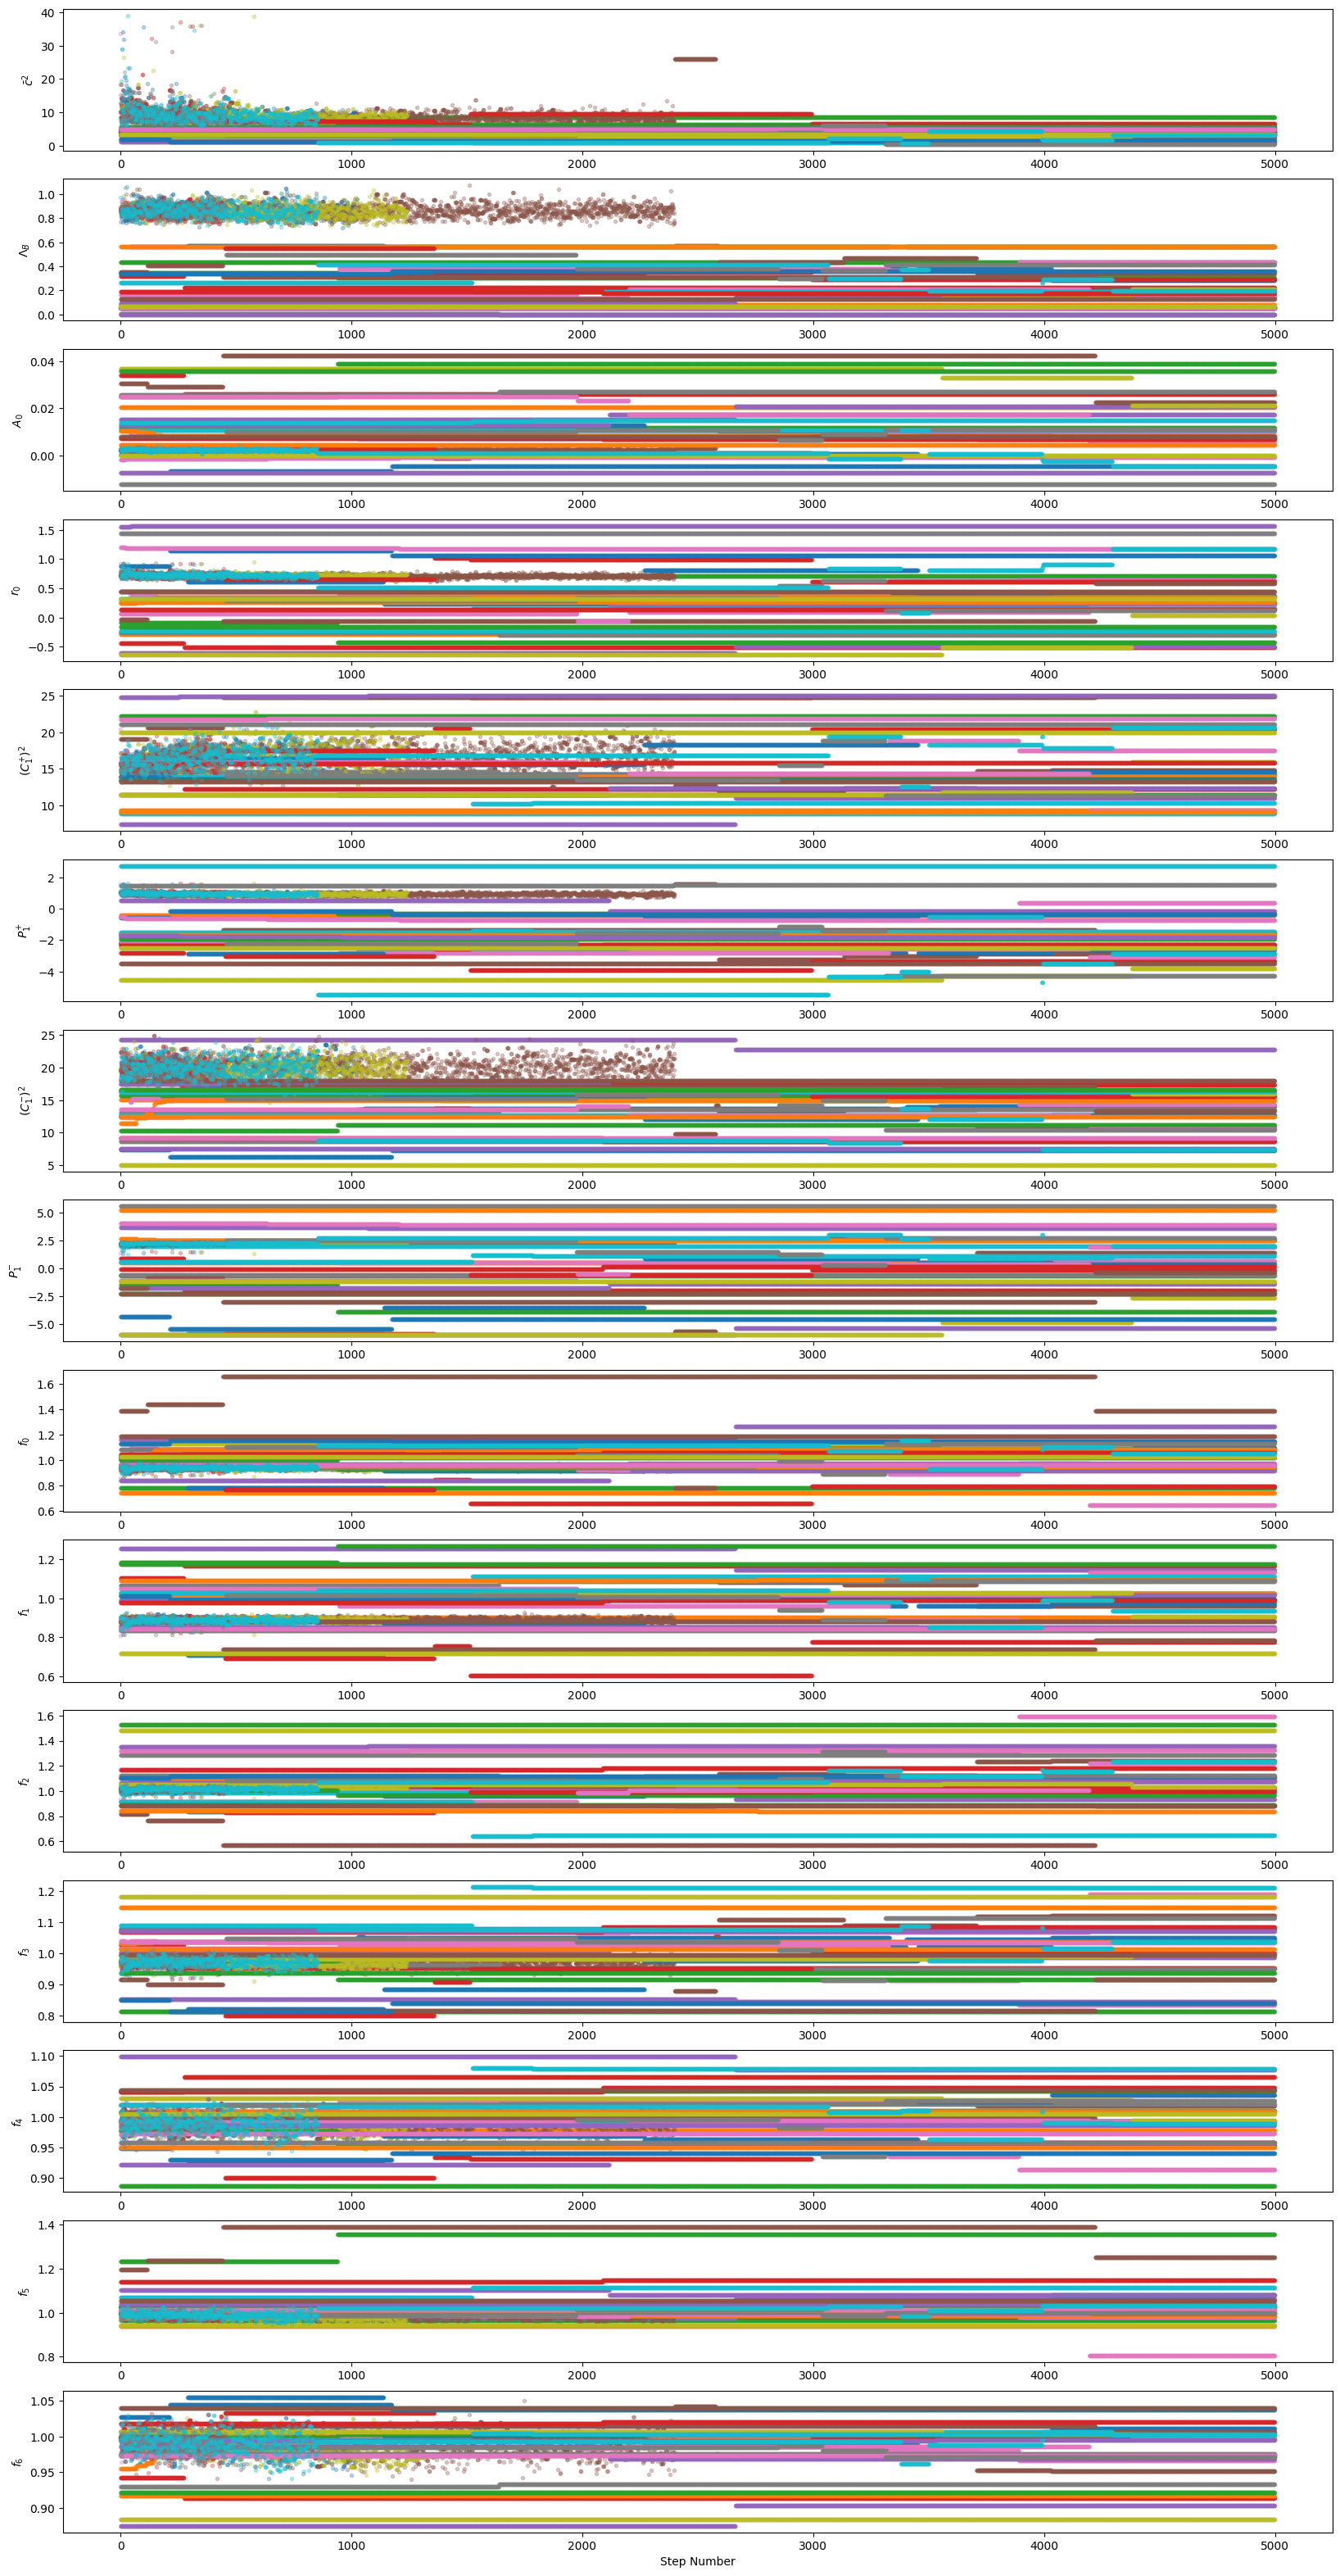

In [23]:
def generate_trace_plot(samples_not_flat):
    # Generate the trace plot given a set of samples
    fig, axes = plt.subplots(samples_not_flat.shape[2], figsize = (20, 40))
    for i in range(0, samples_not_flat.shape[2]):
        ax = axes[i]
        for j in range(0, samples_not_flat.shape[1]):
            ax.plot(samples_not_flat[:, :, i][:, j], '.', alpha = 0.3)
        # ax.plot(samples_not_flat[:, :, i][:, 0], '.', alpha = 0.3)
            ax.set_ylabel(labels[i])
    axes[-1].set_xlabel('Step Number')
    plt.show()

generate_trace_plot(samples_not_flat)

In [16]:
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(150000, 15)


In [17]:
# Compute the autocorrelation times and thin
ac_s = integrated_time(samples_not_flat)
print(ac_s)
ac = int(np.ceil(np.max(ac_s)))
samples_not_flat = samples_not_flat[::ac, :, :]

/Users/andrius/ohiou/research/he3alpha-sampler/autocorr_time.py:39: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [627.30140283          nan 605.29452318          nan 609.3562215
 618.22601523 630.2205821  597.41703153 610.7974412  578.00826665
          nan          nan          nan          nan 586.09370678]

In [18]:
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(150000, 15)


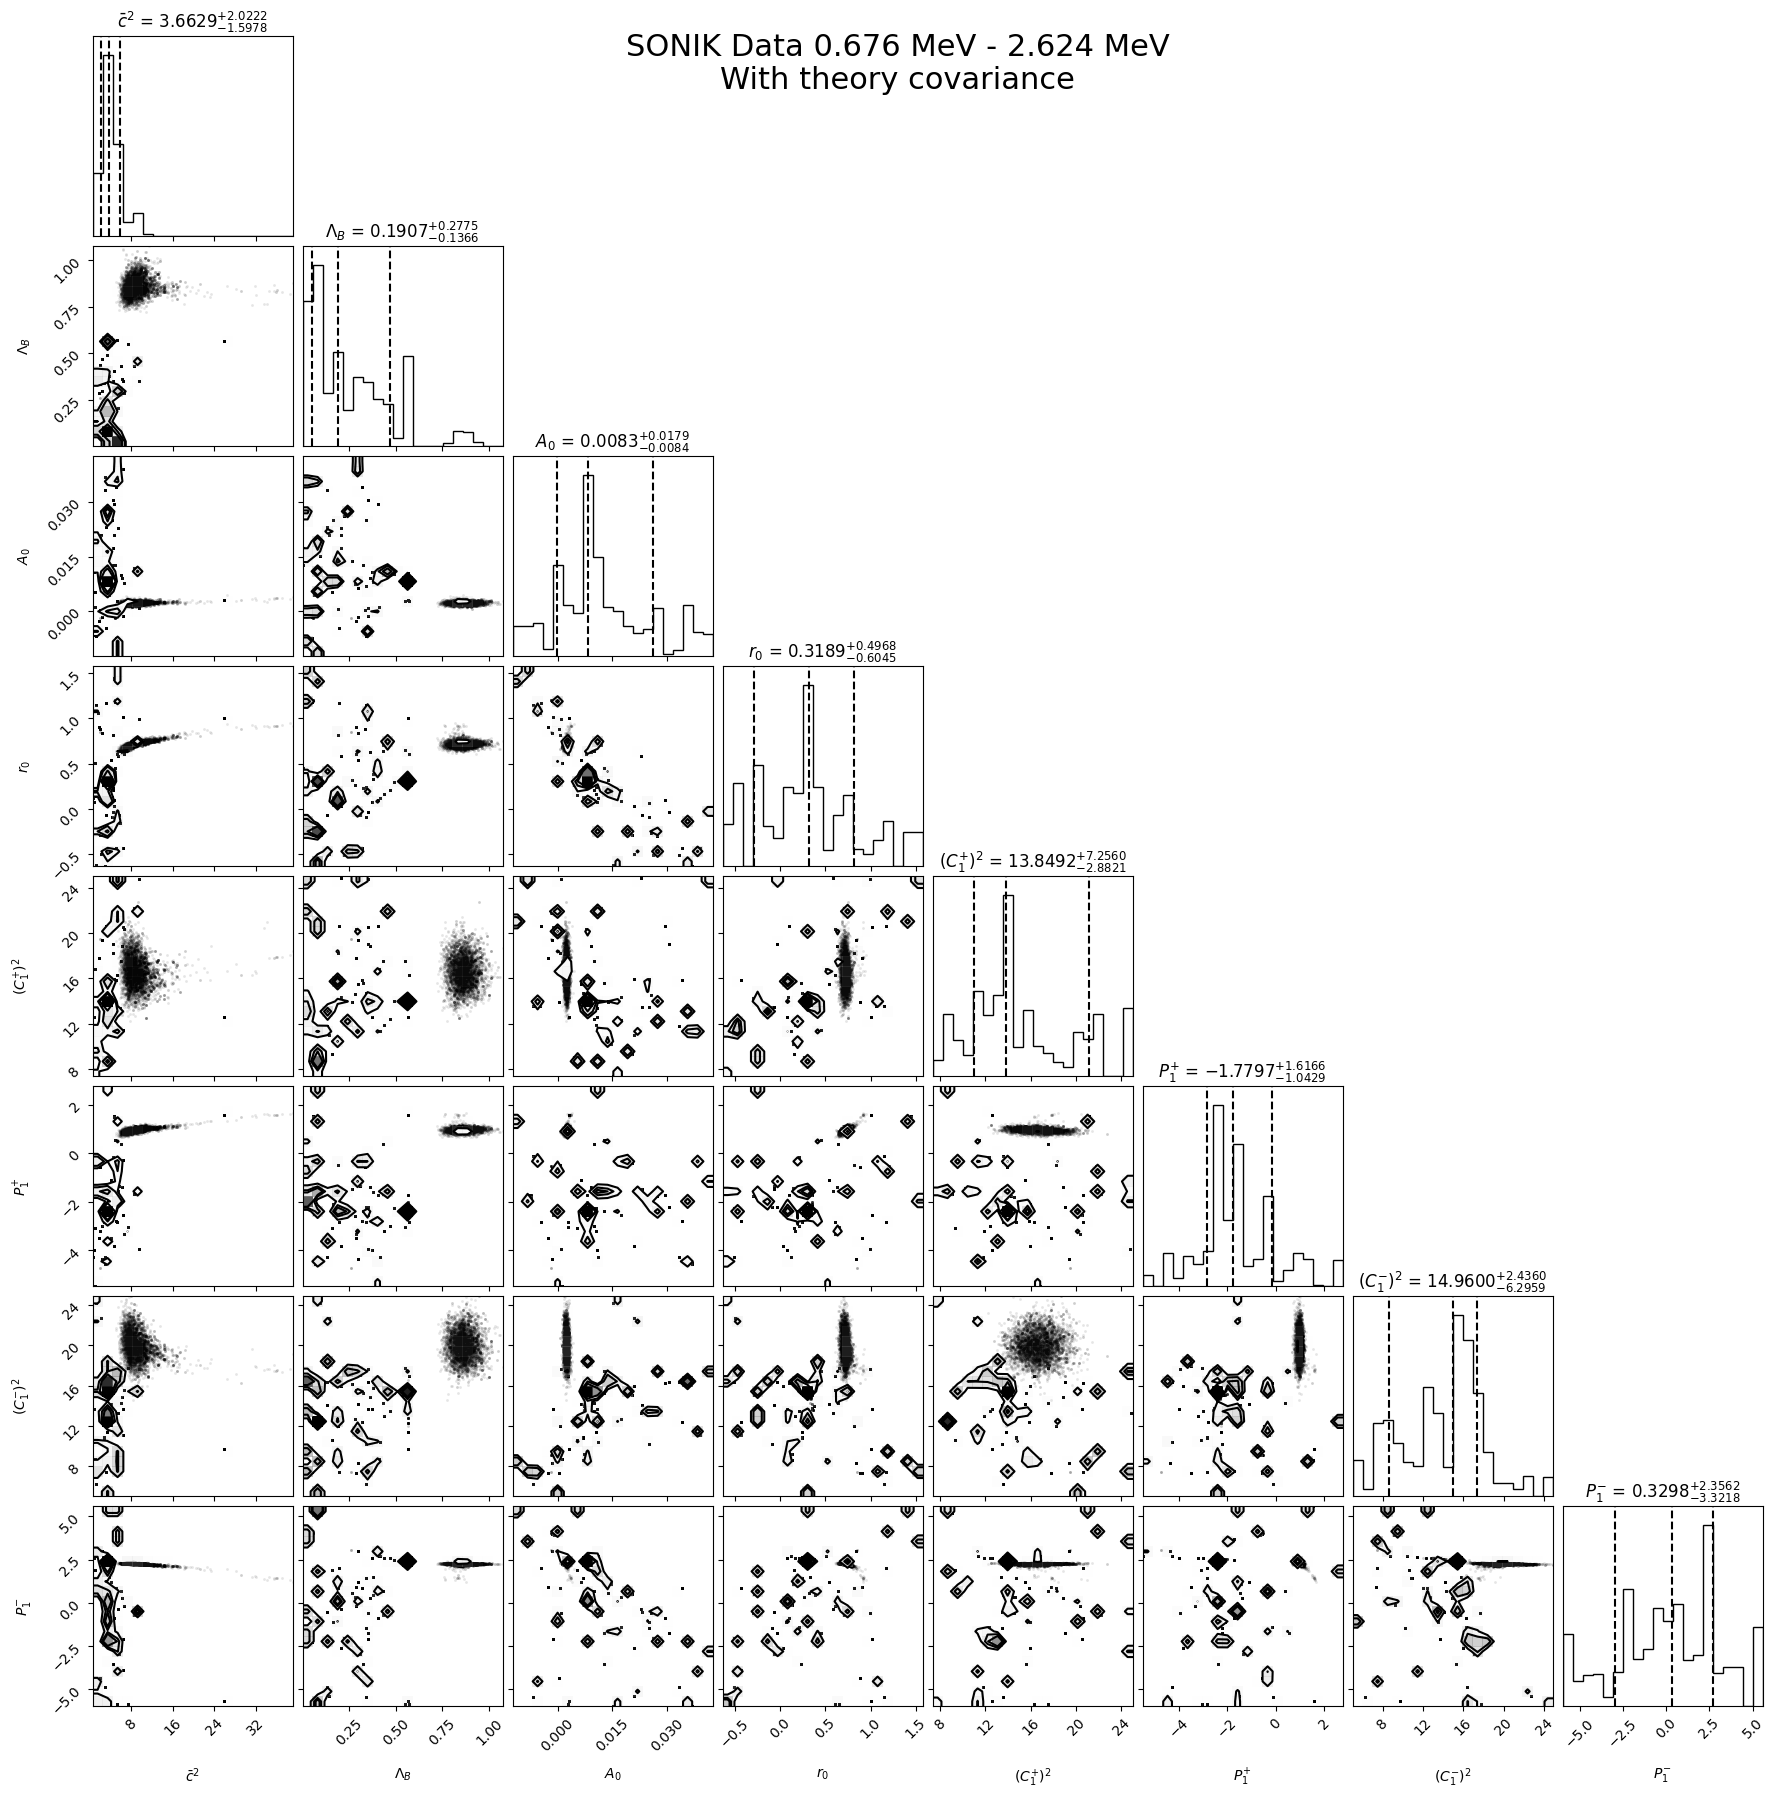

In [22]:
corner.corner(samples[:, :model.erp_dim + 2], labels = labels[:model.erp_dim + 2], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle(titles[number], fontsize = 22)
plt.show()